# Info agregada por Cele

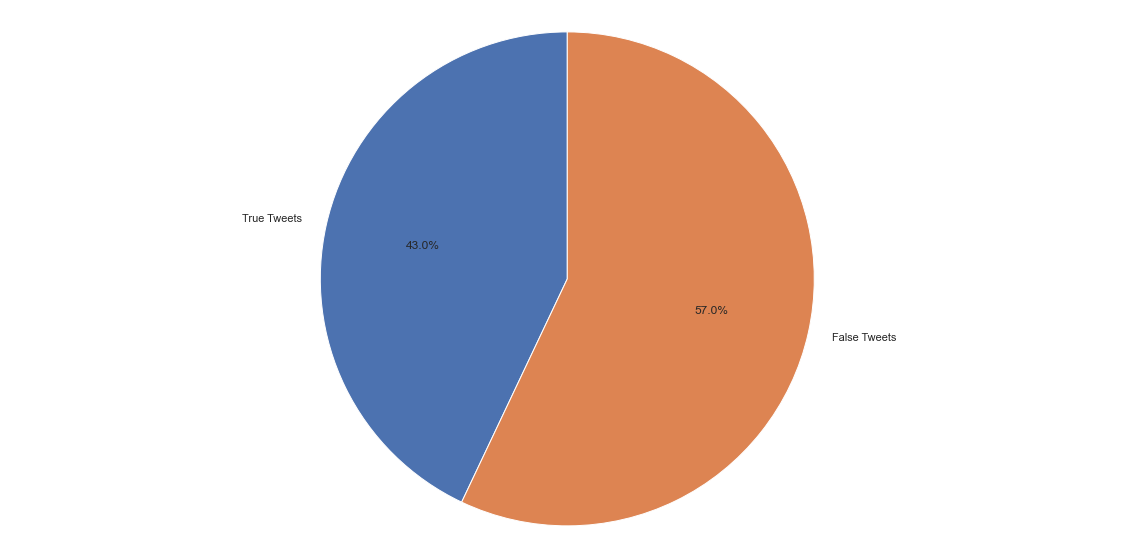

In [103]:

tweet_totals = dataset['longitud'].count()
tweet_true_count = tweet_len_true.count()
tweet_false_count = tweet_len_false.count()

sns.set()

labels = 'True Tweets', 'False Tweets'
sizes = [tweet_true_count, tweet_false_count]

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=False, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

## Análisis de los hashtags

In [84]:
# extrae los hashtags de un texto y devuelve una lista 
def hashtags(text):
    result = []
    for token in text.split():
        if token[0]=='#':
            result.append(token.replace('#', '').lower())
    return result    

text = 'Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all'
hashtags(text)

['earthquake']

In [85]:
dataset['hashtags'] = dataset.text.apply(lambda x : hashtags(x))
dataset.head(5)

,keyword,location,text,target,longitud,hashtags
id,,,,,,
1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,True,69,[earthquake]
4,NaN,NaN,Forest fire near La Ronge Sask. Canada,True,38,[]
5,NaN,NaN,All residents asked to 'shelter in place' are ...,True,133,[]
6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",True,65,[wildfires]
7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,True,88,"[alaska, wildfires]"


In [86]:
df_hashtags = dataset.explode('hashtags')
df_hashtags.head(20)

,keyword,location,text,target,longitud,hashtags
id,,,,,,
1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,True,69,earthquake
4,NaN,NaN,Forest fire near La Ronge Sask. Canada,True,38,NaN
5,NaN,NaN,All residents asked to 'shelter in place' are ...,True,133,NaN
6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",True,65,wildfires
7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,True,88,alaska
7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,True,88,wildfires
8,NaN,NaN,#RockyFire Update => California Hwy. 20 closed...,True,110,rockyfire
8,NaN,NaN,#RockyFire Update => California Hwy. 20 closed...,True,110,cafire
8,NaN,NaN,#RockyFire Update => California Hwy. 20 closed...,True,110,wildfires


In [87]:
# hay que ver si vale la pena porque hay muy pocos hashtags en comparacion al tamaño del dataset
df_hashtags.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9219 entries, 1 to 10873
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   keyword   9138 non-null   object
 1   location  6080 non-null   object
 2   text      9219 non-null   object
 3   target    9219 non-null   bool  
 4   longitud  9219 non-null   int64 
 5   hashtags  3340 non-null   object
dtypes: bool(1), int64(1), object(4)
memory usage: 441.1+ KB


In [88]:
top_hashtags_series = df_hashtags.hashtags.value_counts().nlargest(50)
top_hashtags = pd.DataFrame(top_hashtags_series).reset_index()
top_hashtags.columns = ['hashtags','Cantidad']
top_hashtags.head()


,hashtags,Cantidad
0,news,72
1,hot,30
2,prebreak,30
3,best,30
4,???,23


In [89]:
top_hashtags.Cantidad.sum()

633

c:\users\germa\documents\proyectos python\tp1\venv\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 137 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\users\germa\documents\proyectos python\tp1\venv\lib\site-packages\matplotlib\backends\backend_agg.py:183: RuntimeWarning: Glyph 137 missing from current font.
  font.set_text(s, 0, flags=flags)


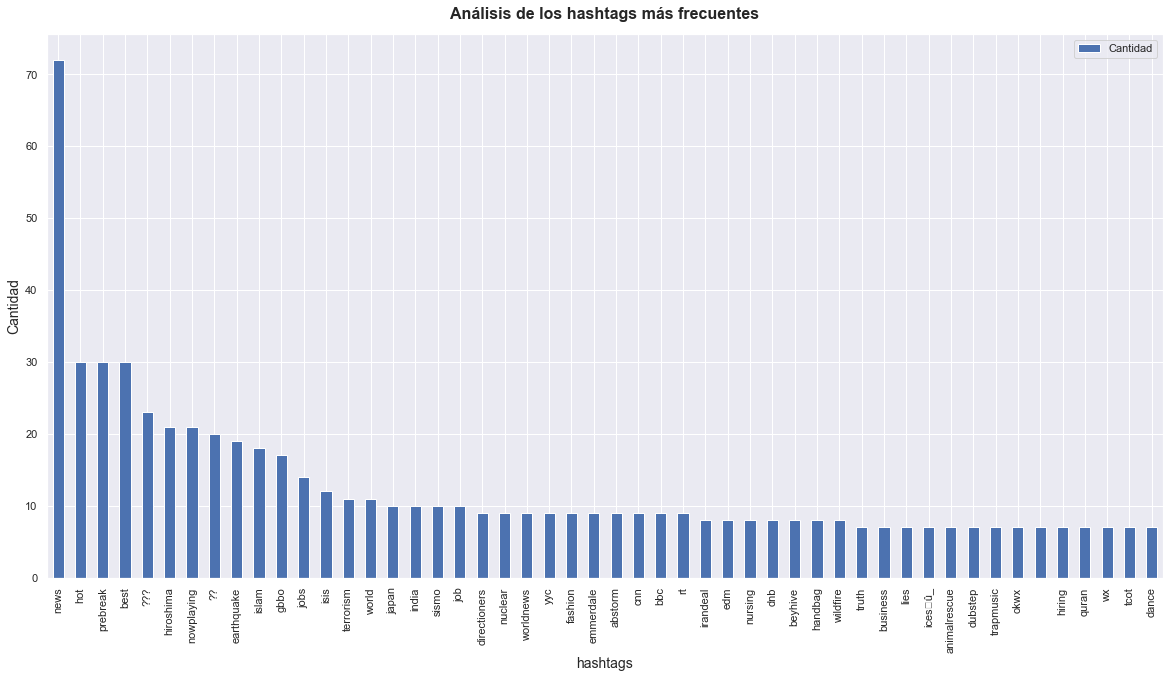

In [105]:

fig, ax = plt.subplots()


plt.xlabel("Hashtags",fontsize=14)
plt.ylabel('Cantidad',fontsize=14)
plt.title('Análisis de los hashtags más frecuentes',fontsize=16,fontweight='bold', pad = 15)

top_hashtags.plot.bar(x='hashtags',y='Cantidad', ax = ax)

plt.show()

## Análisis por ubicacion

Text(0.5, 1.0, 'Análisis de las ubicaciones más frecuentes')

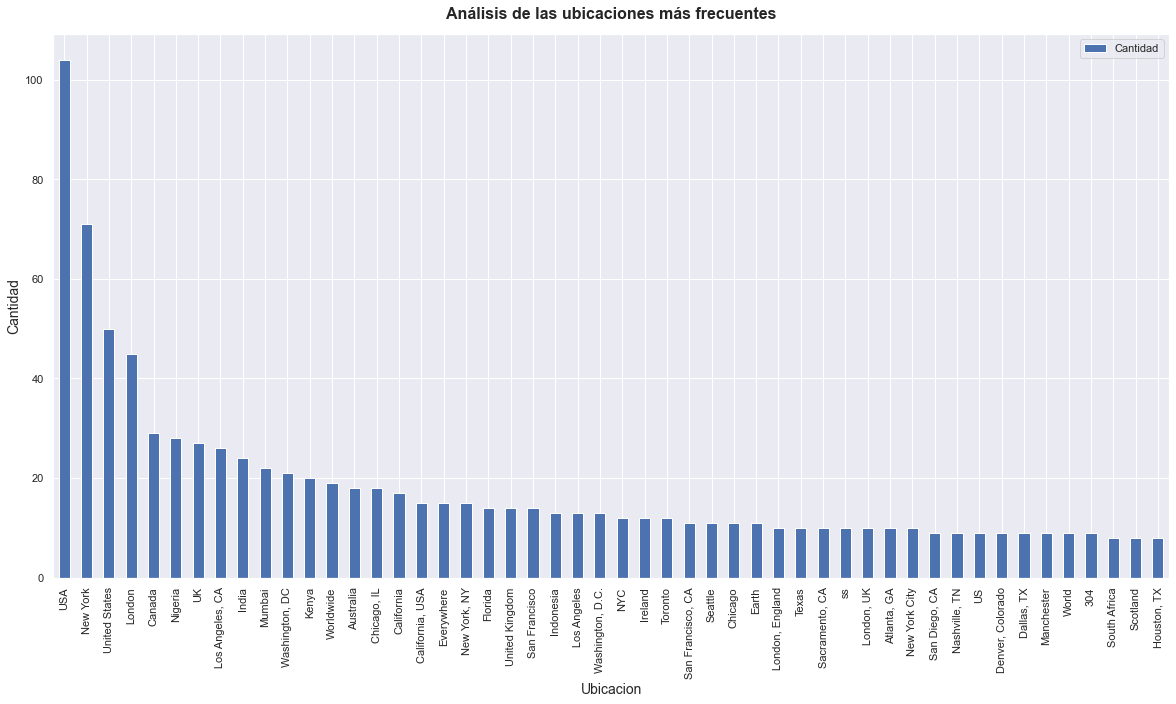

## Análisis por keywords

In [97]:
dataset.keyword.value_counts()

fatalities               45
deluge                   42
armageddon               42
sinking                  41
body%20bags              41
                         ..
forest%20fire            19
epicentre                12
threat                   11
inundation               10
radiation%20emergency     9
Name: keyword, Length: 221, dtype: int64

In [98]:
dataset.keyword.isnull().value_counts()

False    7552
True       61
Name: keyword, dtype: int64

In [99]:
top_keywords = dataset.keyword.value_counts().reset_index()
top_keywords.columns = ['Keywords', 'Cantidad']

top_keywords.head(5)

,Keywords,Cantidad
0,fatalities,45
1,deluge,42
2,armageddon,42
3,sinking,41
4,body%20bags,41


In [100]:
top_keywords.describe()
# estan distribuidas bastante uniformemente

,Cantidad
count,221.000000
mean,34.171946
std,4.786091
min,9.000000
25%,33.000000
50%,35.000000
75%,37.000000
max,45.000000


Text(0.5, 1.0, 'Análisis de las keywords más frecuentes')

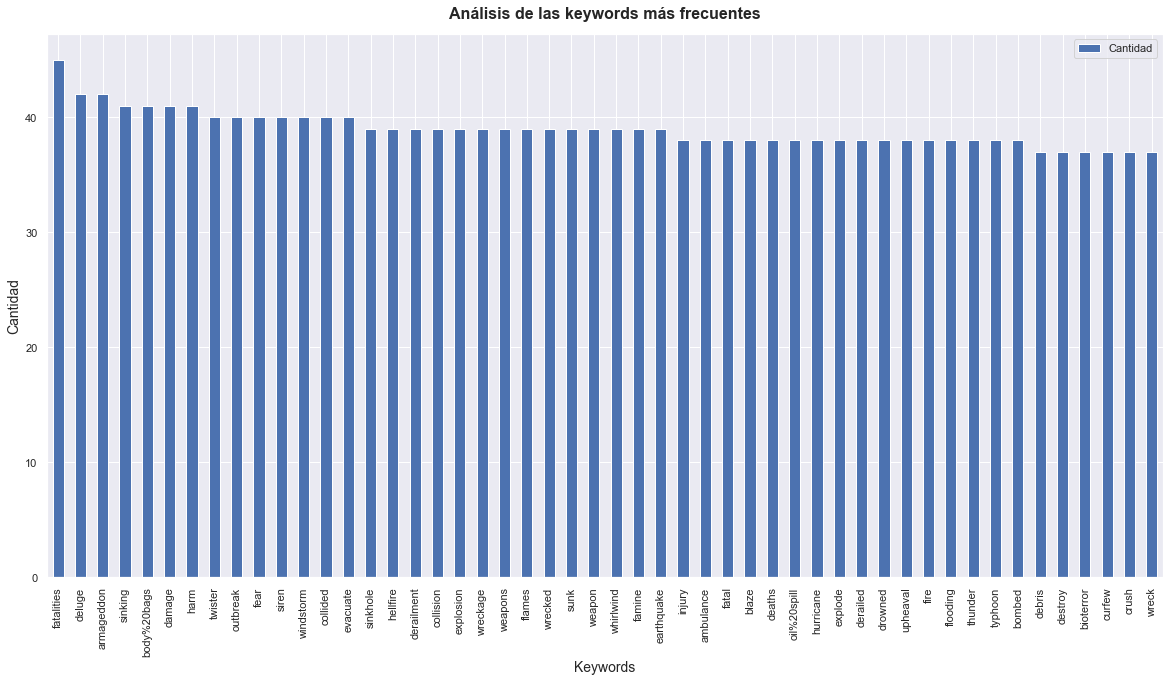

In [107]:
fig, ax = plt.subplots()

top_keywords.nlargest(50,'Cantidad').plot(kind='bar', x = 'Keywords', ax = ax)

plt.xlabel("Keywords",fontsize=14)
plt.ylabel('Cantidad',fontsize=14)
plt.title('Análisis de las keywords más frecuentes',fontsize=16,fontweight='bold', pad = 15)


#agrego texto para probar cambios 

# TEXTO 2 PARA VER HISTORIAL 

# ahora esto lo agrego con mi usuario 


# Info agregada por ...

In [102]:
# Pongan toda la info en celdas como estas